In [ ]:
# TensorFlow 2.0.0 is required for this code to work.
# Uncomment and run the following line to install the CPU version.
# !pip install tensorflow==2.0.0-beta0

### Import necessary modules

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import shuffle
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
import os
from functools import reduce

### Get a list of all hashtags

In [26]:
json_file_names = os.listdir('json_files')
# Remove the 5 char .json file ending to isolate hashtag name
hashtags = [hashtag[:-5] for hashtag in json_file_names]

In [37]:
hashtag_dfs = []
for hashtag in hashtags: 
    hashtag_dfs.append(pd.read_json(f'json_files/{hashtag}.json'))
df = reduce(lambda x, y: pd.concat([x, y]), hashtag_dfs)

In [41]:
img_size = 160 # All images will be resized to 160x160
img_shape = (160, 160, 3)

def prepare_image(img_path, height=img_size, width=img_size):
    """Downsample and scale image to prepare it for neural network"""
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img)
    img = tf.cast(img, tf.float32)
    img = (img/127.5) - 1
    img = tf.image.resize(img, (height, width))
    # Reshape B&W images to match dimensions of color images
    if img.shape != (160, 160, 3):
        img = tf.concat([img, img, img], axis=2)
    return img

In [51]:
pics = []
for i, row in df.iterrows():
    name = row['image_local_name']
    hashtag = row['search_hashtag']
    img_path = f'data/{hashtag}/{name}'
    try:
        img = prepare_image(img_path)
        pics.append({'pic': img, 'hashtag': hashtag})
    except:
        # If a file in the list isn't in 
        # storage, skip it and continue
        pass

In [52]:
type(pics[64]['pic'])

tensorflow.python.framework.ops.EagerTensor

W0620 14:07:42.810135 4518581696 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


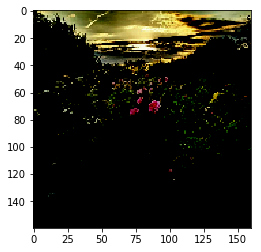

In [53]:
plt.imshow(pics[64]['pic']);

In [54]:
# Create the base model from the pre-trained model MobileNet V2
base_model = MobileNetV2(input_shape=img_shape, include_top=False, weights='imagenet')

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

neural_network = tf.keras.Sequential([
  base_model,
  global_average_layer,
])

In [55]:
def extract_features(image_dict):
    """Return a vector of 1280 deep features for image."""
    image = image_dict['pic']
    image_np = image.numpy()
    images_np = np.expand_dims(image_np, axis=0)
    image_np.shape, images_np.shape
    deep_features = neural_network.predict(images_np)
    image_dict['deep_features'] = deep_features[0]
    return image_dict

In [56]:
deep_features = list(map(extract_features, pics))

In [57]:
shuffle(deep_features)
train_size = int(len(deep_features) * .7)
train, test = deep_features[:train_size], deep_features[train_size:]

In [58]:
train[0].keys()

dict_keys(['pic', 'hashtag', 'deep_features'])

In [59]:
pic = train[0]

W0620 14:09:02.115994 4518581696 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


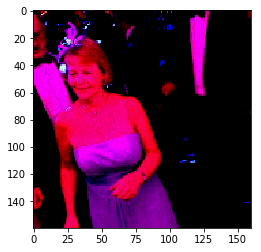

In [64]:
plt.imshow(pic['pic']);

In [61]:
pic['hashtag']

'wedding'

In [62]:
pic['deep_features'].shape

(1280,)

In [63]:
pic['pic'].shape

TensorShape([160, 160, 3])